In [19]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import xarray as xr
import matplotlib.colors as pltc
import geopandas
import datetime as dt
from scipy import stats
from sklearn import preprocessing
import s3fs
import matplotlib as mpl
from scipy.stats import skew
mpl.rcParams['pdf.fonttype'] = 42

## Cubic feet to cubic meters conversion factor
cfs_2_cms = 0.0283168466

In [26]:
comid = 23551772

shp = geopandas.read_file("../data/VIC_UW/shapefiles/columbia_seg.shp")
# shp = shp.loc[shp['POI_ID']==comid]
# seg_ids = np.array(shp['seg_id'])
shp

,DrainID,Region,tosegment2,tosegment,seg_id,seg_id2,POI_ID,TOCOMID2,To_POI_ID,ToFTYPE,...,start_y,TopElev,start_lon,start_lat,end_x,end_y,BotElev,end_lon,end_lat,geometry
0,5447,17,17906894,6894,6892,17906892,0.0,0,0,None,...,3498210.0,1002.0,-119.58342,52.73771,-1.605930e+06,3.495300e+06,776.0,-119.24664,52.76475,"LINESTRING (-1629435.000 3498210.000, -1629180..."
1,5448,17,17906894,6894,6893,17906893,0.0,0,0,None,...,3490490.0,801.0,-119.26432,52.71579,-1.605930e+06,3.495300e+06,776.0,-119.24664,52.76475,"LINESTRING (-1608405.000 3490485.000, -1608450..."
2,5446,17,17906896,6896,6894,17906894,0.0,0,0,None,...,3495300.0,776.0,-119.24664,52.76475,-1.597140e+06,3.490200e+06,730.0,-119.10677,52.73849,"LINESTRING (-1605930.000 3495300.000, -1605900..."
3,5449,17,17906896,6896,6895,17906895,0.0,0,0,None,...,3491750.0,1038.0,-119.06224,52.76043,-1.597140e+06,3.490200e+06,730.0,-119.10677,52.73849,"LINESTRING (-1593555.000 3491745.000, -1593600..."
4,5450,17,17906898,6898,6896,17906896,0.0,0,0,None,...,3490200.0,730.0,-119.10677,52.73849,-1.595250e+06,3.485820e+06,693.0,-119.06541,52.70324,"LINESTRING (-1597140.000 3490200.000, -1597080..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6381,0,17,17001328,1328,5726,17005726,25104318.0,25104315,23412937,ArtificialPath,...,2534030.0,1009.0,-118.16795,43.94496,-1.756024e+06,2.533093e+06,991.0,-118.15387,43.93868,"LINESTRING (-1756957.049 2534034.735, -1756949..."
6382,0,17,17001328,1328,5727,17005727,25104321.0,25104315,23412937,ArtificialPath,...,2533970.0,1082.0,-118.09198,43.95733,-1.756024e+06,2.533093e+06,991.0,-118.15387,43.93868,"LINESTRING (-1750727.914 2533974.431, -1750922..."
6383,0,17,17001322,1322,5728,17005728,25105799.0,23409833,23409741,ArtificialPath,...,2524920.0,631.0,-116.93782,44.06453,-1.658665e+06,2.528229e+06,625.0,-116.95283,44.09250,"LINESTRING (-1658177.913 2524923.667, -1658201..."
6384,0,17,17004979,4979,5729,17005729,917630001.0,24338792,24338794,ArtificialPath,...,2933110.0,878.0,-114.28725,48.21225,-1.361907e+06,2.927671e+06,849.0,-114.25813,48.16579,"LINESTRING (-1363073.313 2933113.181, -1363105..."


In [8]:
# ## Open modeled datasets and extract data at segment locations.
# pnwVIC = xr.open_mfdataset('../data/VIC_UW/pnwNP_Gages_VIC.nc')
# pnwVIC = pnwVIC.where(pnwVIC['reachID'].isin(seg_ids),drop=True)

# pnwPRMS = xr.open_mfdataset('../data/VIC_UW/pnwNP_Gages_PRMS.nc')
# pnwPRMS = pnwPRMS.where(pnwPRMS['reachID'].isin(seg_ids),drop=True)


## Open NWM from NOAA AWS bucket
s3_path = 's3://noaa-nwm-retro-v2-zarr-pds' #nwm 2.0

# Connect to S3
s3 = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(root=s3_path, s3=s3, check=False)

# load the dataset
ds = xr.open_zarr(store=store, consolidated=True)

In [9]:
reach_id = 23551772
timerange = slice('1979-01-31', '2011-12-31')
dat = ds.sel(feature_id=reach_id,
             time=timerange).streamflow.persist() 

# This step takes a bit longer because it's actually returning the data
dat = dat.resample(time='1d').mean()

tetNWM = pd.DataFrame(dat.to_pandas())
tetNWM['time'] = pd.to_datetime(tetNWM.index)
tetNWM.columns = ["streamflow_NWM2d0","time"]
tetNWM = tetNWM.reset_index(drop=True)
tetNWM

,streamflow_NWM2d0,time
0,0.170000,1993-01-01
1,0.170000,1993-01-02
2,0.170000,1993-01-03
3,0.170000,1993-01-04
4,0.170000,1993-01-05
...,...,...
6934,0.270000,2011-12-27
6935,0.270000,2011-12-28
6936,0.262917,2011-12-29
6937,0.281667,2011-12-30


In [11]:
df = tetNWM.copy()
df['water_year'] = df.time.dt.year.where(df.time.dt.month < 10, df.time.dt.year + 1)
df

,streamflow_NWM2d0,time,water_year
0,0.170000,1993-01-01,1993
1,0.170000,1993-01-02,1993
2,0.170000,1993-01-03,1993
3,0.170000,1993-01-04,1993
4,0.170000,1993-01-05,1993
...,...,...,...
6934,0.270000,2011-12-27,2012
6935,0.270000,2011-12-28,2012
6936,0.262917,2011-12-29,2012
6937,0.281667,2011-12-30,2012


In [13]:
df['7Q10'] = df['streamflow_NWM2d0'].rolling(window=7).mean()

In [14]:
lf7q10 = df.groupby(['water_year']).min()
lf7q10 = lf7q10.drop(['time','streamflow_NWM2d0'],axis=1)
lf7q10 = lf7q10[df['7Q10'].isnull().groupby(df['water_year']).sum() <= 36.6]
lf7q10 = lf7q10[lf7q10['7Q10']>0]

In [15]:
lf7q10["RI"] = (1+len(lf7q10))/lf7q10['7Q10'].rank(method = "min")
lf7q10["ExcProb"] = 1/lf7q10["RI"]

In [16]:
lf7q10

,7Q10,RI,ExcProb
water_year,,,
1993,0.120000,7.000000,0.142857
1994,0.127024,5.250000,0.190476
1995,0.110000,21.000000,0.047619
1996,0.267202,1.050000,0.952381
1997,0.220714,1.105263,0.904762
1998,0.186607,1.166667,0.857143
1999,0.149048,2.100000,0.476190
2000,0.140000,3.500000,0.285714
2001,0.140000,3.500000,0.285714


In [20]:
#Measures of the distribution
Xbar = np.mean(np.log10(lf7q10['7Q10']))
S = np.std(np.log10(lf7q10['7Q10']))
g = skew(np.log10(lf7q10['7Q10']))
 
# #calculate z, K, to plot the fitted Pearson Type III
# QyearlyMins <- QyearlyMins %>% 
#   mutate(z = 4.91 * ((1 / ReturnInterval) ^ 0.14 - (1 - 1 / ReturnInterval) ^ 0.14)) %>%
#   mutate(K = (2 / g) * (((1 + (g * z) / 6 - (g ^ 2) / 36) ^ 3) - 1) ) %>%
#   mutate(Qfit = 10^(Xbar + (K * S)))

lf7q10["z"] = 4.91 * ((1 / lf7q10["RI"])**0.14 -(1 - 1 / lf7q10["RI"])**0.14)
lf7q10["K"] = (2/g) * ((((lf7q10["z"] - (g/6))*(g/6)+1)**3)-1)
# lf7q10["K"] = (2/g) * (((1 + (g/lf7q10["z"])/6-(g**2)/36)**3) - 1)
lf7q10["Qfit"] = 10**(Xbar + (lf7q10["K"] * S))

In [21]:
lf7q10

,7Q10,RI,ExcProb,z,K,Qfit
water_year,,,,,,
1993,0.120000,7.000000,0.142857,-1.066066,-1.025117,0.125151
1994,0.127024,5.250000,0.190476,-0.874100,-0.880190,0.128995
1995,0.110000,21.000000,0.047619,-1.670522,-1.432773,0.114942
1996,0.267202,1.050000,0.952381,1.670522,1.857266,0.228420
1997,0.220714,1.105263,0.904762,1.308915,1.366671,0.206186
1998,0.186607,1.166667,0.857143,1.066066,1.057459,0.193298
1999,0.149048,2.100000,0.476190,-0.059448,-0.175866,0.149424
2000,0.140000,3.500000,0.285714,-0.563932,-0.629446,0.135926
2001,0.140000,3.500000,0.285714,-0.563932,-0.629446,0.135926


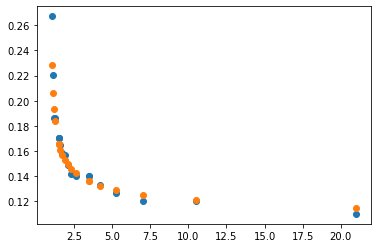

In [22]:
plt.scatter(lf7q10["RI"],lf7q10['7Q10'])
plt.scatter(lf7q10["RI"],lf7q10['Qfit'])

In [23]:
RetIntCalc = 10
z = 4.91 * ((1 / RetIntCalc)**0.14 -(1 - 1 / RetIntCalc)**0.14)
K = (2/g) * ((((z - (g/6))*(g/6)+1)**3)-1)
# K = (2/g) * ((((1 + (g/z))/6-((g**2)/36))**3) - 1)
# PearsonQY= np.exp(Xbar + (K * S))
10**(Xbar + (K * S))

0.12120821884020858

In [ ]:
# for i in range(len(shp)):
pos = [22]
for i in pos:
    print(shp['gage'][i])
    gage = '*'+str(shp['gage'][i])+'*'
    file = glob.glob("../data/pnwNP_modeledData/"+gage)[0]

    datMain = pd.read_csv(file).drop(['Unnamed: 0','gage'],axis=1)
    datMain['time'] = pd.to_datetime(datMain['time'])
    datMain['time'] = datMain['time'].dt.tz_localize(None)
    ######################
    ### Plot full streamflow record
    ######################
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(10,6))
    ax = datMain.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['purple','green','crimson','grey'])
    ax.set_xlabel('Time')
    ax.set_ylabel('Streamflow $(m^3/s)$')
    ax.set_title(shp['station_nm_x'][i])

    plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_streamflow.pdf")
    plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_streamflow.png",dpi=300)

    ######################
    ## Plot streamflow from 2000 - 2004
    ######################

    sub = datMain[ (datMain["time"] >= '2000-01-01') & (datMain["time"] <= '2004-12-31')]
    ax = sub.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['purple','green','crimson','grey'])
    ax.set_xlabel('Time')
    ax.set_ylabel('Streamflow $(m^3/s)$')
    ax.set_title(shp['station_nm_x'][i])
    # ax.set_xlim(np.min(sub['time']),np.max(sub['time']))

    plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_streamflowSubset.pdf")
    plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_streamflowSubset.png",dpi=300)

    ######################
    ## Make a normalized dataframe for plotting
    ######################

    tt = datMain
    tt.index = datMain['time']
    tt =  tt.drop('time',axis=1)
    tt = pd.DataFrame(preprocessing.minmax_scale(tt))
    tt.index = datMain['time']
    tt.columns = ["streamflow_VIC","streamflow_PRMS","streamflow_NWM2d0","streamflow_NWIS"]

    tt.to_csv('../data/pnwNP_modeledDataNormalized/'+str(shp['gage'][i])+"_normalized.csv")


    ######################
    #### Plot 1 to 1
    ######################

    fig, axs = plt.subplots(1,3, sharey=True,figsize=(18,6),subplot_kw=dict(box_aspect=1))
    fig.suptitle(shp['station_nm_x'][i])


    pt = (0, 0)
    plt.tight_layout(pad=0.4, w_pad=1, h_pad=0.5)
    axs[0].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_VIC"],alpha = 0.5,color = "purple",s=10)
    axs[1].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_PRMS"],alpha = 0.5,color = 'green',s=10)
    axs[2].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_NWM2d0"],alpha = 0.5,color = 'crimson',s=10)
    axs[0].axline(pt,slope=1, color='black')
    axs[1].axline(pt,slope=1, color='black')
    axs[2].axline(pt,slope=1, color='black')
    axs[0].set_ylabel('Normalized VIC Streamflow')
    axs[1].set_ylabel('Normalized PRMS Streamflow')
    axs[2].set_ylabel('Normalized NWM 2.0 Streamflow')
    axs[1].set_xlabel('Normalized USGS NWIS Streamflow')
    axs[0].set_ylim(0,1)
    axs[0].set_xlim(0,1)
    axs[1].set_ylim(0,1)
    axs[1].set_xlim(0,1)
    axs[2].set_ylim(0,1)
    axs[2].set_xlim(0,1)

    plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_1to1.pdf",bbox_inches='tight')
    plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_1to1.png",dpi=300,bbox_inches='tight')